### Bayesian Inference for A/B Testing
#### A & B are option which we want to compare. We have different number of test instances for both of these. 
#### This script uses Bayesian Inference to figure out the difference between these opions and also to come up with a confidence interval for the result. 

In [1]:
%matplotlib inline
import pymc3 as pm 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize

In [19]:
#Generate Data for A/B Testing, true_A, true_B will be unknowns in real scenario

true_A = 0.6 #True Conversion Ratio for option-A
true_B = 0.4 #True Conversion Ratio for option-B
N_A = 1000
N_B = 700

observations_A = stats.bernoulli.rvs(true_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_B, size=N_B)
print("Obs from Option A: ", observations_A[:30], "...")
print("Obs from Option B: ", observations_B[:30], "...")
print("Generted conversion ratio for A",sum(observations_A)/N_A)
print("Generted conversion ratio for B",sum(observations_B)/N_B)

Obs from Option A:  [1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1] ...
Obs from Option B:  [0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0] ...
Generted conversion ratio for A 0.597
Generted conversion ratio for B 0.41285714285714287


In [26]:
#MCMC Sampling with uniform priors and Metropolis algorithm
with pm.Model() as model:
    A_p = pm.Uniform("A_p", 0.3,.85)    
    A_obs = pm.Bernoulli("A_obs", p=A_p, observed=observations_A)
    B_p = pm.Uniform("B_p", 0.1,0.6)    
    B_obs = pm.Bernoulli("B_obs", p=B_p, observed=observations_B)
    delta = pm.Deterministic("delta",A_p - B_p)
    
    step = pm.Metropolis()
    trace = pm.sample(50000,step)
    burned = trace[2000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [B_p]
>Metropolis: [A_p]
Sampling 4 chains: 100%|██████████████████████████████████████████████████| 202000/202000 [01:44<00:00, 1927.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [27]:
delta_samples = burned['delta']
A_p_samples = burned["A_p"]
B_p_samples = burned["B_p"]

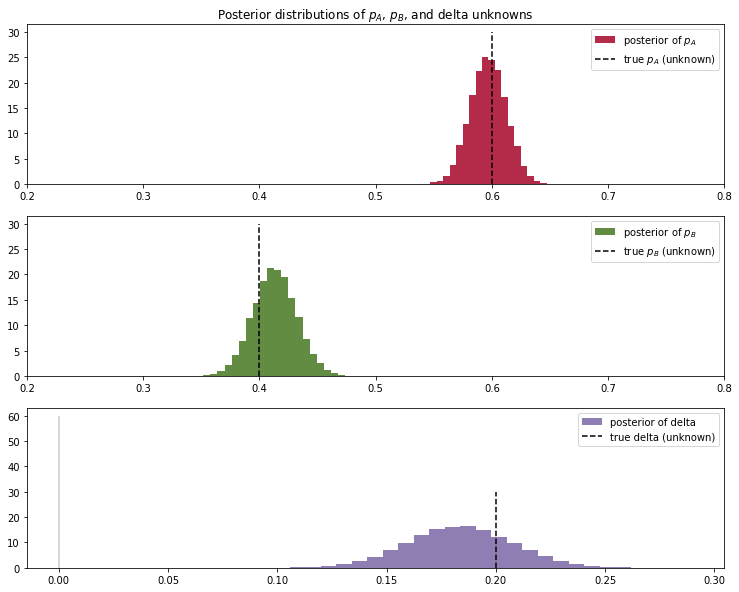

In [28]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0.2, 0.8)
plt.hist(A_p_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_A, 0, 30, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0.2, 0.8)
plt.hist(B_p_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_B, 0, 30, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_A - true_B, 0, 30, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [43]:
#95% conf interval of the difference
np.percentile(delta_samples,[2.5,97.5],axis=0)

array([0.13599621, 0.23122151])